In [189]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from numpyro import handlers
from numpyro.infer.reparam import TransformReparam
import arviz as az

numpyro.set_host_device_count(4)
az.style.use('arviz-darkgrid')

## Data

In [79]:
n_samples = 112
hours_worked = stats.norm(loc=0, scale=1).rvs(n_samples) + 5
answer_unconstrained = 1 - hours_worked + stats.norm(loc=0, scale=0.1).rvs(n_samples)
answer = np.where(
    answer_unconstrained < -4, 0, np.where(answer_unconstrained < -3, 1, 2)
)

hours_sc = (hours_worked - np.mean(hours_worked)) / np.std(hours_worked)

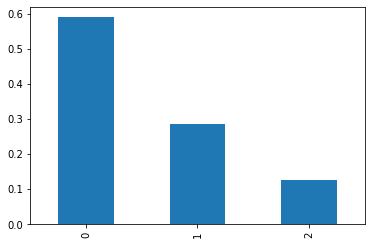

In [40]:
pd.Series(answer).value_counts(normalize=True).sort_index().plot.bar();

## Categorical distribution

In [4]:
samples = dist.Categorical(probs=jnp.array([0.2, 0.5, 0.3])).sample(
    jax.random.PRNGKey(2), sample_shape=(100,)
)
samples

DeviceArray([0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 1, 1, 0, 0, 2, 2, 0,
             2, 1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 2,
             0, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 1, 1, 2, 0, 1, 2, 1, 1,
             1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 2, 1, 0, 2],            dtype=int32)

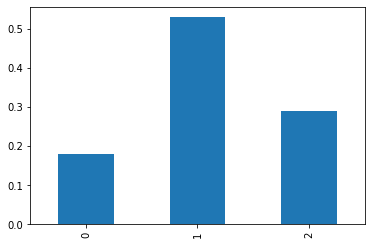

In [15]:
pd.Series(samples).value_counts(normalize=True).sort_index().plot.bar();

def categorical_regression

maybe

## Making ordered categories fit into a Categorical distribution

Let's try thinking...cumulatively...

In [17]:
answer

array([1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0,
       1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1])

In [41]:
pd.Series(answer).value_counts(normalize=True)

0    0.589286
1    0.285714
2    0.125000
dtype: float64

In [46]:
pd.Series(answer).value_counts(normalize=True).cumsum()

0    0.589286
1    0.875000
2    1.000000
dtype: float64

In [52]:
scipy.special.logit(pd.Series(answer).value_counts(normalize=True).cumsum())

0    0.361013
1    1.945910
2         inf
dtype: float64

unconstrained_prediction = model(features)

```
f(0.36, unconstrained_prediction) : log odds of answer being 0
f(1.94, unconstrained_prediction) : log odds of answer being 0 or 1
```

what will `f` be?

Desirable property: the higher `unconstrained_prediction`, the higher the probability of the respondent giving a higher survey answer

Let's try summing them together:

```
0.36 + unconstrained_prediction : log odds of answer being 0
1.94 + unconstrained_prediction : log odds of answer being 0 or 1
```

higher log odds of `answer` being 0 increase ==> lower log odds of `answer` being 1 or greater

So instead, let's subtract:

```
0.36 - unconstrained_prediction : log odds of answer being 0
1.94 - unconstrained_prediction : log odds of answer being 0 or 1
```

In [122]:
predictions = jnp.array(np.random.randn(100))

In [91]:
cutpoints = jnp.array([0.36, 1.94])

DeviceArray([0.58904046, 0.2853117 , 0.12564784], dtype=float32)

In [152]:
jnp.pad(
    cutpoints - predictions[:, jnp.newaxis],
    pad_width=((0, 0), (1, 1)),
    constant_values=(0, 1),
).shape

(100, 4)

In [ ]:
jnp.diff(
    jnp.pad(
        jax.scipy.special.expit(cutpoints), pad_width=(1, 1), constant_values=(0, 1)
    )
)

In [176]:
def ordered_logistic_regression(hours_sc, n_answer, answer=None):

    alpha = numpyro.sample(
        "alpha",
        dist.Normal(0, 1),
    )
    beta = numpyro.sample(
        "beta",
        dist.Normal(0, 0.5),
    )

    predictions = alpha + beta * hours_worked
    cutpoints = numpyro.sample("cutpoints", dist.Normal(0, 1).expand([n_answer - 1]))
    assert cutpoints.shape == (n_answer - 1,)

    probs = numpyro.deterministic(
        "probs",
        jnp.diff(
            jnp.pad(
                jax.scipy.special.expit(cutpoints - predictions[:, jnp.newaxis]),
                pad_width=((0, 0), (1, 1)),
                constant_values=(0, 1),
            )
        ),
    )

    numpyro.sample(
        "obs",
        dist.Categorical(
            probs=probs,
        ),
        obs=answer,
    )

In [172]:
prior_pred = numpyro.infer.Predictive(ordered_logistic_regression, num_samples=100)
prior_predictions = prior_pred(
    jax.random.PRNGKey(93),
    hours_sc=hours_sc,
    n_answer=len(np.unique(answer)),
)

In [173]:
prior_predictions["probs"].shape

(100, 112, 3)

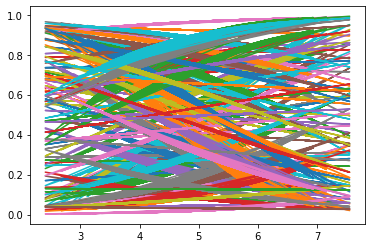

In [174]:
plt.plot(hours_worked, prior_predictions["probs"][:, :, 0].T);

In [180]:
sampler = numpyro.infer.NUTS(ordered_logistic_regression)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(93),
    hours_sc=hours_sc,
    n_answer=len(np.unique(answer)),
    answer=answer,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [181]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha     -0.94      0.60     -0.92     -1.97     -0.02   1250.89      1.00
        beta     -2.71      0.30     -2.71     -3.21     -2.22   2042.41      1.00
cutpoints[0]     -1.06      0.62     -1.05     -2.09     -0.10   1198.14      1.00
cutpoints[1]      1.92      0.62      1.93      0.94      2.97   1335.99      1.00

Number of divergences: 0


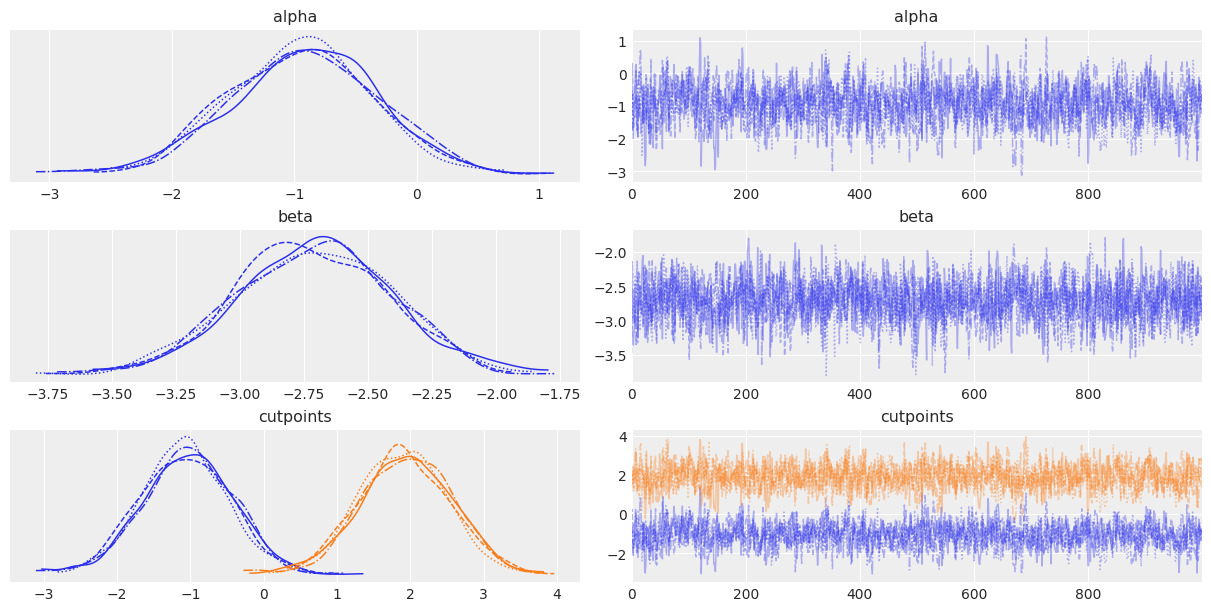

In [190]:
az.plot_trace(az.from_numpyro(mcmc), var_names=['~probs']);